In [1]:
%matplotlib inline


# Segmenting the picture of greek coins in regions

This example uses `spectral_clustering` on a graph created from
voxel-to-voxel difference on an image to break this image into multiple
partly-homogeneous regions.

This procedure (spectral clustering on an image) is an efficient
approximate solution for finding normalized graph cuts.

There are two options to assign labels:

* with 'kmeans' spectral clustering will cluster samples in the embedding space
  using a kmeans algorithm
* whereas 'discrete' will iteratively search for the closest partition
  space to the embedding space.


In [2]:
# Author: Gael Varoquaux <gael.varoquaux@normalesup.org>, Brian Cheung
# License: BSD 3 clause

import time

import numpy as np
from scipy.ndimage import gaussian_filter as scipy_gaussian_filter

import matplotlib.pyplot as plt
import skimage
from skimage.data import coins
from skimage.transform import rescale as skimage_rescale

from sklearn.feature_extraction import image

from sklearn.cluster import spectral_clustering
from sklearn.utils.fixes import parse_version

from scipy import sparse as scipy_sparse

# these were introduced in skimage-0.14
if parse_version(skimage.__version__) >= parse_version("0.14"):
    rescale_params = {"anti_aliasing": False}
else:
    rescale_params = {}

beta = 10
eps = 1e-6
LABELLING_METHODS = ["discretize"]

# Apply spectral clustering (this step goes much faster if you have pyamg
# installed)
N_REGIONS = 25

def create_image_graph(coins, gaussian_filter, rescale, return_as=scipy_sparse.coo_matrix):
    # Resize it to 20% of the original size to speed up the processing
    # Applying a Gaussian filter for smoothing prior to down-scaling
    # reduces aliasing artifacts.
    smoothened_coins = gaussian_filter(coins, sigma=2)
    # Taking the old array for cucim as we don't need to change cucim to support Array API
    # We'll change skimage to support Array API rather.    
    # smoothened_coins = smoothened_coins._array if hasattr(smoothened_coins, '_array') else smoothened_coins
    rescaled_coins = rescale(smoothened_coins, 0.2, mode="reflect", **rescale_params)

    # Convert the image into a graph with the value of the gradient on the
    # edges.

    graph = image.img_to_graph(rescaled_coins, return_as=return_as)
    return rescaled_coins, graph


# Take a decreasing function of the gradient: an exponential
# The smaller beta is, the more independent the segmentation is of the
# actual image. For beta=1, the segmentation is close to a voronoi
def set_graph_data(array, graph):
    graph.data = array.exp(-beta * array.asarray(graph.data) / array.std(array.asarray(graph.data))) + eps
    graph.row = array.asarray(graph.row)
    graph.col = array.asarray(graph.col)
    return graph


def plot_(graph, rescaled_coins, xp):
    for assign_labels in LABELLING_METHODS:
        t0 = time.time()
        labels = spectral_clustering(
            graph, n_clusters=N_REGIONS, assign_labels=assign_labels, random_state=42
        )
        t1 = time.time()
        labels = xp.reshape(labels, rescaled_coins.shape)
        plt.figure(figsize=(5, 5))
        if xp.__name__ == 'cupy.array_api':
            rescaled_coins = rescaled_coins._array.get()
            labels = labels._array.get()
        plt.imshow(rescaled_coins, cmap=plt.cm.gray)
        for l in range(N_REGIONS):
            plt.contour(labels == l, colors=[plt.cm.nipy_spectral(l / float(N_REGIONS))])
        plt.xticks(())
        plt.yticks(())
        title = "Spectral clustering: %s, %.2fs" % (assign_labels, (t1 - t0))
        print(title)
        plt.title(title)
    plt.show()

def segmentation(xp, coins, gaussian_filter, return_as):
    rescaled_coins, graph = create_image_graph(coins, gaussian_filter, skimage_rescale, return_as=return_as)
    graph = set_graph_data(xp, graph)
    plot_(graph, rescaled_coins, xp)

In [3]:
import numpy.array_api as npx
import cupy.array_api as cpx

from cupyx.scipy.ndimage import gaussian_filter as cupy_gaussian_filter
from cupyx.scipy import sparse as cupy_sparse

/tmp/ipykernel_19436/2070595185.py:1: UserWarning: The numpy.array_api submodule is still experimental. See NEP 47.
  import numpy.array_api as npx
/tmp/ipykernel_19436/2070595185.py:2: UserWarning: The numpy.array_api submodule is still experimental. See NEP 47.
  import cupy.array_api as cpx


## Segmentation with NumPy Array

Finding eigsh
Found eigsh
Returning embedding
Spectral clustering: discretize, 4.43s


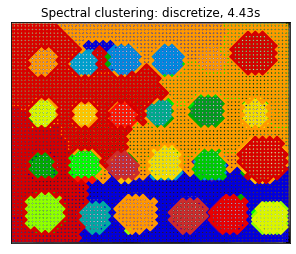

In [4]:
segmentation(
    xp=npx,
    coins=npx.asarray(coins()),
    gaussian_filter=scipy_gaussian_filter,
    return_as=scipy_sparse.coo_matrix
)

## Segmentation with CuPy Array

plot_(graph1, rescaled_coins1)

Finding eigsh
Found eigsh
Returning embedding
Spectral clustering: discretize, 7.28s


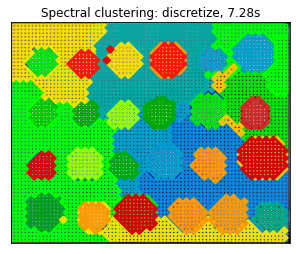

In [5]:
segmentation(
    xp=cpx,
    coins=cpx.asarray(coins()),
    gaussian_filter=cupy_gaussian_filter,
    return_as=cupy_sparse.coo_matrix
)